In [1]:
import d2l
from matplotlib import pyplot as plt
import numpy as np
import os
from PIL import Image
import torch
from torch import nn

import shared_loader

from torchvision import transforms
import torchvision

### Import the shared data loader

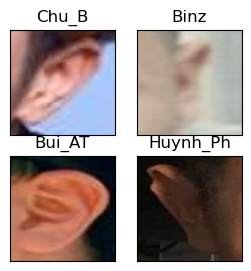

In [2]:
data = shared_loader.EarData()

batch = next(iter(data.get_dataloader(train=True)))
data.visualize(batch)

In [3]:
def init_cnn(module):  #@save
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

In [4]:
class CNNbaseline(d2l.Classifier):
    """The LeNet-5 model."""
    def __init__(self, num_classes=164):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.LazyLinear(84), nn.ReLU(),
            nn.LazyLinear(num_classes))
    

### Use CUDA if available

In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## Train Scratch Model

In [6]:
def model_training(model, data, optimizer, loss_fn, epochs = 10, early_stopping = True, verbose = True):
    # overall loss value for each epoch:
    loss_train = []
    loss_valid = []
    accuracy_valid = []

    best_val_loss = float('inf')
    patience_counter = 0
    patience = 25

    for epoch in range(epochs) :
        if verbose and (epoch+1)%10 == 0:
            print("epoch", epoch + 1,)
        model.train()
        loss_values = [] # loss values for each batch
        for batch_X, batch_y in data.train_dataloader() :
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            preds = model(batch_X)
            loss = loss_fn(preds, batch_y)
            loss_values.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_train.append(np.mean(loss_values))
        model.eval()
        loss_values = []
        accuracy_values = []
        for batch_X, batch_y in data.val_dataloader() :
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            with torch.no_grad():
                preds = model(batch_X)
                #print(preds)
                loss = loss_fn(preds, batch_y)
                loss_values.append(loss.item())
                accuracy_values.append(model.accuracy(preds, batch_y).item())
        
        if early_stopping:     
            val_loss = np.mean(loss_values)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                # Save the best model weights here
                torch.save(model.state_dict(), 'best_model.pth')
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered at epoch {epoch}.")
                    break
                
        loss_valid.append(np.mean(loss_values))
        accuracy_valid.append(np.mean(accuracy_values))
        if verbose and epoch%10 == 0:
            print(f"accuracy: {accuracy_valid[-1]:.8f}")
    return model, loss_train, loss_valid, accuracy_valid

In [7]:
baseline_model = CNNbaseline()
baseline_model = baseline_model.to(device)

/usr/local/anaconda3/2023.03/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [8]:
batch_X = next(iter(data.get_dataloader(train=True)))[0]
batch_X = batch_X.to(device)
baseline_model.apply_init([batch_X], init_cnn)
optimizer = torch.optim.SGD(baseline_model.parameters(), lr=0.1)
loss_fn = nn.CrossEntropyLoss()

In [9]:
baseline_model, bass_loss_train, bass_loss_valid, bass_accuracy_valid = model_training(baseline_model, data, 
                                                                                       optimizer, loss_fn,
                                                                                      epochs = 100, early_stopping = False)


accuracy: 0.00000000
epoch 10
accuracy: 0.00000000
epoch 20
accuracy: 0.00000000
epoch 30
accuracy: 0.00000000
epoch 40
accuracy: 0.00000000
epoch 50
accuracy: 0.00000000
epoch 60
accuracy: 0.00000000
epoch 70
accuracy: 0.00000000
epoch 80
accuracy: 0.00000000
epoch 90
accuracy: 0.00000000
epoch 100


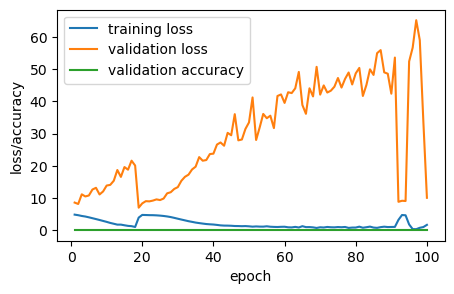

In [10]:
from matplotlib import pyplot as plt
plt.figure(figsize=(5,3))
plt.plot(range(1, len(bass_loss_train)+1), bass_loss_train, label='training loss')
plt.plot(range(1, len(bass_loss_valid)+1), bass_loss_valid, label='validation loss')
plt.plot(range(1, len(bass_loss_valid)+1), bass_accuracy_valid, label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('loss/accuracy')
plt.legend();

## Finetune a Pretrained Model

In [11]:
finetune_net = torchvision.models.resnet18(weights='IMAGENET1K_V1')
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 164)
nn.init.xavier_uniform_(finetune_net.fc.weight);

In [12]:
def accuracy(Y_hat, Y, averaged=True):
    """Compute the number of correct predictions."""
    Y_hat = d2l.reshape(Y_hat, (-1, Y_hat.shape[-1]))
    preds = d2l.astype(d2l.argmax(Y_hat, axis=1), Y.dtype)
    compare = d2l.astype(preds == d2l.reshape(Y, -1), d2l.float32)
    return d2l.reduce_mean(compare) if averaged else compare

In [13]:
model=finetune_net
model=model.to(device)
batch_size=128
param_group=True
learning_rate = 0.001
train_iter = data.get_dataloader(train=True)
test_iter = data.get_dataloader(train=True)

loss_fn = nn.CrossEntropyLoss()

if param_group:
    params_1x = [param for name, param in model.named_parameters() 
                 if name not in ["fc.weight", "fc.bias"]]
    optimizer = torch.optim.SGD([{'params': params_1x},
                                 {'params': model.fc.parameters(),
                                'lr': learning_rate * 10}],
                                lr=learning_rate, weight_decay=0.001)
else:
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                weight_decay=0.001)

In [14]:
epochs = 10
# overall loss value for each epoch:
loss_train = []
loss_valid = []
accuracy_valid = []
for epoch in range(epochs) :
    print("epoch", epoch + 1,)
    model.train()
    loss_values = [] # loss values for each batch
    for batch_X, batch_y in train_iter :
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        preds = model(batch_X)
        loss = loss_fn(preds, batch_y)
        loss_values.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train.append(np.mean(loss_values))
    model.eval()
    loss_values = []
    accuracy_values = []
    for batch_X, batch_y in test_iter :
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        with torch.no_grad():
            preds = model(batch_X)
            loss = loss_fn(preds, batch_y)
            loss_values.append(loss.item())
            accuracy_values.append(accuracy(preds, batch_y).item())
    loss_valid.append(np.mean(loss_values))
    accuracy_valid.append(np.mean(accuracy_values))
    print ("accuracy: ", accuracy_valid[-1])

epoch 1
accuracy:  0.04047762594182775
epoch 2
accuracy:  0.1490822615539146
epoch 3
accuracy:  0.2789556538368728
epoch 4
accuracy:  0.364399115755627
epoch 5
accuracy:  0.44522039127503177
epoch 6
accuracy:  0.46352491961414793
epoch 7
accuracy:  0.5681605038152246
epoch 8
accuracy:  0.6323352090032154
epoch 9
accuracy:  0.6644058147044044
epoch 10
accuracy:  0.720190246580498
